# ECOM09A Atividade 2 Etapa 4

[Proposta](https://docs.google.com/document/d/e/2PACX-1vS-DZIR4CM_abUC7bgTtd3x5X_QCdh8Y3FdVdEQbTfTRricAduuQK5i_yQIHdMoKddV6g9QONtp-BuN/pub)

(14/06/2024) Utilizando um modelo do Huggingfaces de Text Classification:
- https://huggingface.co/models?pipeline_tag=text-classification
- Obter um resultado melhor que o notebook da etapa 3 (GloVe)

Código abaixo baseado em:

https://medium.com/@prakashram1327/building-a-text-classification-model-using-distilbert-703c1409696c

## Base de dados de artigos da Folha UOL

In [ ]:
import os
from IPython.core.display import display, HTML
from google.colab import files, userdata

if not os.path.exists('/content/articles.csv'):
  if not os.path.exists('kaggle.json'):
    try:
      kaggle_key = userdata.get('kaggle_key')
      open('kaggle.json','w').write(kaggle_key)
    except:
      files.upload()

  !pip install -q kaggle

  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !rm kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download 'marlesson/news-of-the-site-folhauol'
  !unzip -qq news-of-the-site-folhauol.zip
  !rm news-of-the-site-folhauol.zip

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
 95% 177M/187M [00:02<00:00, 82.9MB/s]
100% 187M/187M [00:02<00:00, 86.4MB/s]


## Instalando Biblioteca do HuggingFaces (Transformers)

In [ ]:
!pip install -q datasets transformers[torch]

In [ ]:
import transformers
print('Transformes:',transformers.__version__)
import datasets
print('Datasets:',datasets.__version__)

Transformes: 4.41.2
Datasets: 2.19.2


## Carregando Base de Dados no Format Transformes

In [ ]:
import pandas as pd

df_folha = pd.read_csv('articles.csv',encoding="utf8")

df_folha.drop(["title","date","subcategory","link"],axis=1,inplace=True)
df_folha.drop_duplicates(subset=["text"],inplace=True)
df_folha.dropna(inplace=True)

df_folha.reset_index(drop=True,inplace=True)
df_folha = df_folha[df_folha['category'].isin(list(df_folha['category'].value_counts()[:7].index))]

df_folha.head()

,text,category
0,Com a possibilidade de uma condenação impedir ...,poder
1,"Para Oumou Sangaré, cantora e ativista malines...",ilustrada
2,Três reportagens da Folha foram vencedoras do ...,poder
3,A Disney divulgou na noite desta segunda-feira...,ilustrada
4,"O CBSS, banco da holding Elopar dos sócios Bra...",mercado


In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset, Value, ClassLabel, Features, DatasetDict

labels, class_names = pd.factorize(df_folha['category'],sort=True)
class_names = list(class_names.values)
df_folha['labels'] = labels

train, test = train_test_split(df_folha[['text','labels']].sample(n='????'), test_size=0.2, random_state=42)

features = Features({"text": Value("string"),"labels": ClassLabel(names=class_names)})

dataset = DatasetDict({
    "train": Dataset.from_pandas(train, '???', preserve_index=False),
    "test": Dataset.from_pandas(test, '???', preserve_index=False)
    })

print('dataset =',dataset)
print("dataset['train'].features =",dataset['train'].features)

id2label = {id:label for id, label in enumerate(class_names)}
label2id = {label:id for id,label in id2label.items()}
print('id2label =',id2label)
print('label2id =', label2id)

In [ ]:
dataset['train'][7]['text'], dataset['train'][7]['labels']

## Modelo Neural

In [ ]:
model_checkpoint = '????' # não usar o 'distilbert-base-uncased'
batch_size = 16

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer(dataset['train'][7]['text'])

### Convertendo Dataset para Tokens

In [ ]:
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset

## Ajuste-Fino

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding

# Load pre-trained DistilBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels='????')

# Prepare data collator for padding sequences
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define training arguments
training_args = TrainingArguments('????')

# Define Trainer object for training the model
trainer = Trainer('???')

# Train the model
trainer.train()

# Save the trained model
trainer.save_model('model')

## Avaliando Modelo Treinado

In [ ]:
outputs = trainer.predict(encoded_dataset['test'])

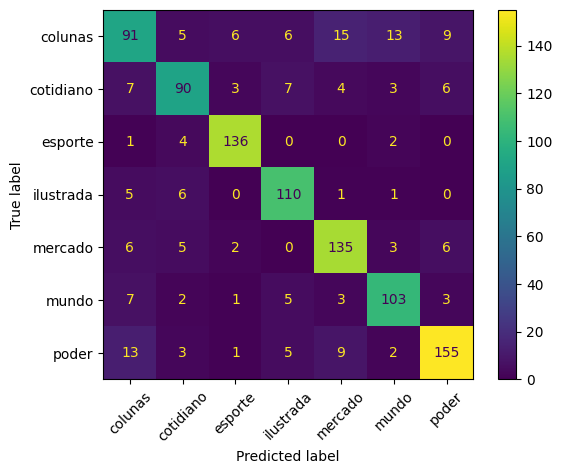

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = encoded_dataset['test'].features['labels'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))

              precision    recall  f1-score   support

     colunas       0.70      0.63      0.66       145
   cotidiano       0.78      0.75      0.77       120
     esporte       0.91      0.95      0.93       143
   ilustrada       0.83      0.89      0.86       123
     mercado       0.81      0.86      0.83       157
       mundo       0.81      0.83      0.82       124
       poder       0.87      0.82      0.84       188

    accuracy                           0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000

